# DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    isTraining = tf.placeholder(tf.bool, [], name='isTraining')
    return actions, states, targetQs, isTraining

In [9]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [10]:
def model_loss(actions, states, targetQs, action_size, hidden_size, isTraining):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size, training=isTraining)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('actor')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)
    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.isTraining = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, isTraining=self.isTraining)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
env.observation_space, env.action_space, \
env.observation_space.low, env.observation_space.high, \
env.action_space.n

(Box(4,),
 Discrete(2),
 array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32),
 2)

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
state = env.reset()

for _ in range(memory_size):
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    memory.buffer.append([state, action, next_state, reward, float(done)])
    
    state = next_state
    
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    n_episodes = 111111111111111
    
    # Training episodes/epochs
    for ep in range(n_episodes):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.isTraining: False})
                action = np.argmax(action_logits)
                
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # minibatch
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # targetQs
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states, 
                                                                              model.isTraining: False})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)

            # train
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs, 
                                                                     model.isTraining: False})
            loss_batch.append(loss)
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:76.0000 R:76.0 loss:1.1077 exploreP:0.9925
Episode:1 meanR:49.0000 R:22.0 loss:1.3975 exploreP:0.9903
Episode:2 meanR:38.0000 R:16.0 loss:1.5633 exploreP:0.9888
Episode:3 meanR:33.7500 R:21.0 loss:1.6321 exploreP:0.9867
Episode:4 meanR:29.4000 R:12.0 loss:2.0147 exploreP:0.9856
Episode:5 meanR:27.8333 R:20.0 loss:2.2199 exploreP:0.9836
Episode:6 meanR:26.7143 R:20.0 loss:2.4183 exploreP:0.9817
Episode:7 meanR:25.8750 R:20.0 loss:2.6574 exploreP:0.9797
Episode:8 meanR:26.6667 R:33.0 loss:3.2026 exploreP:0.9765
Episode:9 meanR:26.5000 R:25.0 loss:4.1558 exploreP:0.9741
Episode:10 meanR:25.0000 R:10.0 loss:4.5303 exploreP:0.9731
Episode:11 meanR:26.0000 R:37.0 loss:5.2315 exploreP:0.9696
Episode:12 meanR:27.0000 R:39.0 loss:6.9518 exploreP:0.9659
Episode:13 meanR:26.0000 R:13.0 loss:9.0671 exploreP:0.9646
Episode:14 meanR:25.8667 R:24.0 loss:10.8202 exploreP:0.9623
Episode:15 meanR:26.7500 R:40.0 loss:13.2567 exploreP:0.9585
Episode:16 meanR:26.7647 R:27.0 loss:17.5271 exp

Episode:135 meanR:21.9500 R:14.0 loss:275.6075 exploreP:0.7357
Episode:136 meanR:21.8500 R:8.0 loss:298.1786 exploreP:0.7352
Episode:137 meanR:21.8000 R:36.0 loss:299.7454 exploreP:0.7326
Episode:138 meanR:21.7600 R:13.0 loss:247.2180 exploreP:0.7316
Episode:139 meanR:21.8000 R:19.0 loss:270.8282 exploreP:0.7303
Episode:140 meanR:21.6200 R:12.0 loss:256.8975 exploreP:0.7294
Episode:141 meanR:21.6400 R:20.0 loss:263.9918 exploreP:0.7280
Episode:142 meanR:21.6200 R:14.0 loss:282.0130 exploreP:0.7269
Episode:143 meanR:21.6900 R:18.0 loss:250.2579 exploreP:0.7257
Episode:144 meanR:21.8400 R:33.0 loss:248.4116 exploreP:0.7233
Episode:145 meanR:21.8200 R:22.0 loss:234.8714 exploreP:0.7217
Episode:146 meanR:21.5200 R:23.0 loss:235.4486 exploreP:0.7201
Episode:147 meanR:21.1800 R:14.0 loss:241.5660 exploreP:0.7191
Episode:148 meanR:20.7100 R:21.0 loss:239.3302 exploreP:0.7176
Episode:149 meanR:20.7800 R:19.0 loss:200.6332 exploreP:0.7163
Episode:150 meanR:20.5400 R:14.0 loss:237.9704 exploreP:

Episode:270 meanR:34.1100 R:16.0 loss:0.7901 exploreP:0.4917
Episode:271 meanR:34.3900 R:38.0 loss:0.6919 exploreP:0.4899
Episode:272 meanR:34.4100 R:25.0 loss:0.7862 exploreP:0.4887
Episode:273 meanR:34.5700 R:31.0 loss:0.6923 exploreP:0.4872
Episode:274 meanR:34.4400 R:25.0 loss:0.5814 exploreP:0.4860
Episode:275 meanR:34.7100 R:42.0 loss:0.6801 exploreP:0.4840
Episode:276 meanR:34.8300 R:24.0 loss:0.6991 exploreP:0.4829
Episode:277 meanR:34.9400 R:25.0 loss:0.6733 exploreP:0.4817
Episode:278 meanR:34.9700 R:25.0 loss:0.6451 exploreP:0.4805
Episode:279 meanR:35.1500 R:29.0 loss:0.7375 exploreP:0.4791
Episode:280 meanR:35.4700 R:48.0 loss:0.6440 exploreP:0.4769
Episode:281 meanR:35.7200 R:33.0 loss:0.7011 exploreP:0.4754
Episode:282 meanR:36.0000 R:40.0 loss:0.6350 exploreP:0.4735
Episode:283 meanR:36.1500 R:28.0 loss:0.5795 exploreP:0.4722
Episode:284 meanR:36.2100 R:28.0 loss:0.6320 exploreP:0.4709
Episode:285 meanR:36.5400 R:50.0 loss:0.6058 exploreP:0.4686
Episode:286 meanR:36.540

Episode:406 meanR:19.9600 R:19.0 loss:0.5416 exploreP:0.3658
Episode:407 meanR:19.9400 R:17.0 loss:0.4982 exploreP:0.3652
Episode:408 meanR:19.8200 R:13.0 loss:0.5287 exploreP:0.3648
Episode:409 meanR:19.7200 R:16.0 loss:0.4814 exploreP:0.3642
Episode:410 meanR:19.7300 R:13.0 loss:0.5159 exploreP:0.3638
Episode:411 meanR:19.7300 R:17.0 loss:0.5245 exploreP:0.3632
Episode:412 meanR:19.5700 R:15.0 loss:0.5092 exploreP:0.3626
Episode:413 meanR:19.4900 R:13.0 loss:0.4376 exploreP:0.3622
Episode:414 meanR:19.5600 R:19.0 loss:0.5121 exploreP:0.3615
Episode:415 meanR:19.6600 R:26.0 loss:0.5062 exploreP:0.3606
Episode:416 meanR:19.7600 R:23.0 loss:0.4651 exploreP:0.3598
Episode:417 meanR:19.6200 R:12.0 loss:0.5307 exploreP:0.3594
Episode:418 meanR:19.5900 R:15.0 loss:0.4307 exploreP:0.3588
Episode:419 meanR:19.6300 R:15.0 loss:0.5038 exploreP:0.3583
Episode:420 meanR:19.6600 R:19.0 loss:0.4781 exploreP:0.3577
Episode:421 meanR:19.5700 R:19.0 loss:0.4678 exploreP:0.3570
Episode:422 meanR:19.490

Episode:541 meanR:16.5900 R:16.0 loss:0.4840 exploreP:0.2942
Episode:542 meanR:16.5100 R:13.0 loss:0.4971 exploreP:0.2938
Episode:543 meanR:16.4300 R:15.0 loss:0.5831 exploreP:0.2934
Episode:544 meanR:16.3800 R:14.0 loss:0.4598 exploreP:0.2930
Episode:545 meanR:16.3700 R:16.0 loss:0.4624 exploreP:0.2925
Episode:546 meanR:16.3800 R:16.0 loss:0.5109 exploreP:0.2921
Episode:547 meanR:16.3300 R:14.0 loss:0.4702 exploreP:0.2917
Episode:548 meanR:16.3000 R:20.0 loss:0.4926 exploreP:0.2911
Episode:549 meanR:16.4100 R:25.0 loss:0.5162 exploreP:0.2904
Episode:550 meanR:16.3900 R:16.0 loss:0.4773 exploreP:0.2899
Episode:551 meanR:16.3100 R:12.0 loss:0.4430 exploreP:0.2896
Episode:552 meanR:16.3700 R:18.0 loss:0.4793 exploreP:0.2891
Episode:553 meanR:16.3000 R:14.0 loss:0.5034 exploreP:0.2887
Episode:554 meanR:16.2200 R:13.0 loss:0.4592 exploreP:0.2884
Episode:555 meanR:16.2100 R:14.0 loss:0.4362 exploreP:0.2880
Episode:556 meanR:16.1800 R:14.0 loss:0.5046 exploreP:0.2876
Episode:557 meanR:16.190

Episode:677 meanR:16.4000 R:18.0 loss:0.6111 exploreP:0.2373
Episode:678 meanR:16.3900 R:22.0 loss:0.5163 exploreP:0.2368
Episode:679 meanR:16.4100 R:16.0 loss:0.4691 exploreP:0.2365
Episode:680 meanR:16.4400 R:15.0 loss:0.4996 exploreP:0.2361
Episode:681 meanR:16.4000 R:16.0 loss:0.4880 exploreP:0.2358
Episode:682 meanR:16.4100 R:15.0 loss:0.6045 exploreP:0.2354
Episode:683 meanR:16.3500 R:12.0 loss:0.5484 exploreP:0.2352
Episode:684 meanR:16.3800 R:18.0 loss:0.5986 exploreP:0.2348
Episode:685 meanR:16.3200 R:13.0 loss:0.5813 exploreP:0.2345
Episode:686 meanR:16.3300 R:21.0 loss:0.6517 exploreP:0.2340
Episode:687 meanR:16.3000 R:18.0 loss:0.6782 exploreP:0.2336
Episode:688 meanR:16.2700 R:14.0 loss:0.4689 exploreP:0.2333
Episode:689 meanR:16.2500 R:17.0 loss:0.4976 exploreP:0.2329
Episode:690 meanR:16.3000 R:18.0 loss:0.5359 exploreP:0.2325
Episode:691 meanR:16.3600 R:24.0 loss:0.4862 exploreP:0.2320
Episode:692 meanR:16.3800 R:14.0 loss:0.5090 exploreP:0.2317
Episode:693 meanR:16.310

Episode:814 meanR:16.7400 R:19.0 loss:0.8396 exploreP:0.1911
Episode:815 meanR:16.7700 R:16.0 loss:1.0922 exploreP:0.1909
Episode:816 meanR:16.9000 R:26.0 loss:0.7185 exploreP:0.1904
Episode:817 meanR:16.9000 R:17.0 loss:0.8529 exploreP:0.1901
Episode:818 meanR:16.9200 R:19.0 loss:0.7919 exploreP:0.1897
Episode:819 meanR:16.9600 R:17.0 loss:0.9025 exploreP:0.1894
Episode:820 meanR:16.9900 R:18.0 loss:0.8617 exploreP:0.1891
Episode:821 meanR:17.0300 R:21.0 loss:0.7250 exploreP:0.1887
Episode:822 meanR:17.1200 R:26.0 loss:0.7514 exploreP:0.1883
Episode:823 meanR:17.1900 R:24.0 loss:0.7241 exploreP:0.1878
Episode:824 meanR:17.2400 R:20.0 loss:0.9164 exploreP:0.1875
Episode:825 meanR:17.3100 R:21.0 loss:0.7789 exploreP:0.1871
Episode:826 meanR:17.3400 R:17.0 loss:0.8584 exploreP:0.1868
Episode:827 meanR:17.4200 R:21.0 loss:0.9425 exploreP:0.1864
Episode:828 meanR:17.4700 R:18.0 loss:0.7885 exploreP:0.1861
Episode:829 meanR:17.5200 R:21.0 loss:0.7117 exploreP:0.1858
Episode:830 meanR:17.540

Episode:949 meanR:17.4500 R:16.0 loss:0.6635 exploreP:0.1529
Episode:950 meanR:17.4200 R:16.0 loss:0.7640 exploreP:0.1526
Episode:951 meanR:17.3900 R:15.0 loss:0.9025 exploreP:0.1524
Episode:952 meanR:17.3400 R:16.0 loss:0.9737 exploreP:0.1522
Episode:953 meanR:17.3300 R:13.0 loss:0.7176 exploreP:0.1520
Episode:954 meanR:17.3500 R:17.0 loss:0.7128 exploreP:0.1518
Episode:955 meanR:17.2900 R:18.0 loss:0.8092 exploreP:0.1515
Episode:956 meanR:17.3100 R:17.0 loss:0.8577 exploreP:0.1513
Episode:957 meanR:17.3300 R:20.0 loss:0.7223 exploreP:0.1510
Episode:958 meanR:17.3000 R:18.0 loss:0.8251 exploreP:0.1507
Episode:959 meanR:17.3000 R:14.0 loss:0.7870 exploreP:0.1505
Episode:960 meanR:17.3000 R:16.0 loss:0.6596 exploreP:0.1503
Episode:961 meanR:17.2600 R:14.0 loss:0.6660 exploreP:0.1501
Episode:962 meanR:17.3300 R:21.0 loss:0.7952 exploreP:0.1498
Episode:963 meanR:17.3400 R:15.0 loss:0.7380 exploreP:0.1496
Episode:964 meanR:17.3600 R:19.0 loss:0.8580 exploreP:0.1493
Episode:965 meanR:17.290

Episode:1082 meanR:21.0600 R:20.0 loss:0.8524 exploreP:0.1190
Episode:1083 meanR:21.1500 R:25.0 loss:1.0631 exploreP:0.1187
Episode:1084 meanR:21.2100 R:20.0 loss:1.1220 exploreP:0.1185
Episode:1085 meanR:21.2500 R:22.0 loss:0.7313 exploreP:0.1182
Episode:1086 meanR:21.2200 R:16.0 loss:1.0867 exploreP:0.1181
Episode:1087 meanR:21.1900 R:21.0 loss:1.0353 exploreP:0.1178
Episode:1088 meanR:21.2300 R:21.0 loss:1.0259 exploreP:0.1176
Episode:1089 meanR:21.2000 R:19.0 loss:1.0582 exploreP:0.1174
Episode:1090 meanR:21.2400 R:20.0 loss:1.0654 exploreP:0.1172
Episode:1091 meanR:21.2200 R:19.0 loss:0.9344 exploreP:0.1170
Episode:1092 meanR:21.2800 R:23.0 loss:1.0088 exploreP:0.1168
Episode:1093 meanR:21.2800 R:15.0 loss:1.0344 exploreP:0.1166
Episode:1094 meanR:21.2200 R:15.0 loss:1.0874 exploreP:0.1164
Episode:1095 meanR:21.1900 R:25.0 loss:1.1046 exploreP:0.1162
Episode:1096 meanR:21.2500 R:23.0 loss:1.1848 exploreP:0.1159
Episode:1097 meanR:21.2100 R:19.0 loss:0.9441 exploreP:0.1157
Episode:

Episode:1215 meanR:22.8100 R:23.0 loss:0.9031 exploreP:0.0910
Episode:1216 meanR:22.8700 R:25.0 loss:0.8265 exploreP:0.0908
Episode:1217 meanR:22.8200 R:23.0 loss:1.0877 exploreP:0.0906
Episode:1218 meanR:22.7600 R:19.0 loss:0.9918 exploreP:0.0904
Episode:1219 meanR:22.7200 R:20.0 loss:1.0720 exploreP:0.0903
Episode:1220 meanR:22.7800 R:28.0 loss:1.0814 exploreP:0.0901
Episode:1221 meanR:22.7900 R:17.0 loss:0.8091 exploreP:0.0899
Episode:1222 meanR:22.7600 R:18.0 loss:1.0897 exploreP:0.0898
Episode:1223 meanR:22.6900 R:23.0 loss:0.9082 exploreP:0.0896
Episode:1224 meanR:22.7600 R:25.0 loss:1.0918 exploreP:0.0894
Episode:1225 meanR:22.7600 R:24.0 loss:1.1652 exploreP:0.0892
Episode:1226 meanR:22.7300 R:19.0 loss:1.0643 exploreP:0.0891
Episode:1227 meanR:22.7000 R:20.0 loss:0.9581 exploreP:0.0889
Episode:1228 meanR:22.7800 R:25.0 loss:0.9065 exploreP:0.0887
Episode:1229 meanR:22.8400 R:31.0 loss:1.0927 exploreP:0.0885
Episode:1230 meanR:22.8600 R:22.0 loss:0.9380 exploreP:0.0883
Episode:

Episode:1348 meanR:25.2600 R:21.0 loss:0.8040 exploreP:0.0677
Episode:1349 meanR:25.2100 R:18.0 loss:0.5755 exploreP:0.0676
Episode:1350 meanR:25.2700 R:32.0 loss:0.6183 exploreP:0.0674
Episode:1351 meanR:25.2400 R:27.0 loss:0.7656 exploreP:0.0672
Episode:1352 meanR:25.2100 R:30.0 loss:0.8843 exploreP:0.0671
Episode:1353 meanR:25.1400 R:20.0 loss:0.8291 exploreP:0.0670
Episode:1354 meanR:25.1800 R:29.0 loss:0.8404 exploreP:0.0668
Episode:1355 meanR:25.1800 R:22.0 loss:0.8406 exploreP:0.0667
Episode:1356 meanR:25.0400 R:24.0 loss:0.7009 exploreP:0.0665
Episode:1357 meanR:25.0500 R:25.0 loss:0.7591 exploreP:0.0664
Episode:1358 meanR:25.1400 R:29.0 loss:0.5910 exploreP:0.0662
Episode:1359 meanR:25.1900 R:35.0 loss:0.6734 exploreP:0.0660
Episode:1360 meanR:25.2100 R:25.0 loss:0.7915 exploreP:0.0659
Episode:1361 meanR:25.1700 R:19.0 loss:0.6267 exploreP:0.0658
Episode:1362 meanR:25.2300 R:23.0 loss:0.5545 exploreP:0.0657
Episode:1363 meanR:25.1900 R:23.0 loss:0.7174 exploreP:0.0655
Episode:

Episode:1481 meanR:28.4700 R:75.0 loss:0.6222 exploreP:0.0499
Episode:1482 meanR:28.8300 R:65.0 loss:0.5825 exploreP:0.0496
Episode:1483 meanR:29.4600 R:90.0 loss:0.7141 exploreP:0.0492
Episode:1484 meanR:29.3800 R:17.0 loss:0.8429 exploreP:0.0492
Episode:1485 meanR:29.4500 R:30.0 loss:0.6480 exploreP:0.0491
Episode:1486 meanR:29.5100 R:22.0 loss:0.6521 exploreP:0.0490
Episode:1487 meanR:30.1400 R:84.0 loss:0.6192 exploreP:0.0486
Episode:1488 meanR:30.8000 R:93.0 loss:0.7639 exploreP:0.0483
Episode:1489 meanR:31.5400 R:96.0 loss:0.8852 exploreP:0.0479
Episode:1490 meanR:32.0500 R:81.0 loss:0.6384 exploreP:0.0476
Episode:1491 meanR:31.9900 R:21.0 loss:0.5577 exploreP:0.0475
Episode:1492 meanR:32.0200 R:23.0 loss:0.4881 exploreP:0.0475
Episode:1493 meanR:31.7900 R:17.0 loss:0.4259 exploreP:0.0474
Episode:1494 meanR:31.9400 R:36.0 loss:0.4928 exploreP:0.0473
Episode:1495 meanR:32.0000 R:25.0 loss:0.6358 exploreP:0.0472
Episode:1496 meanR:31.9600 R:23.0 loss:0.5416 exploreP:0.0471
Episode:

Episode:1616 meanR:33.2400 R:21.0 loss:0.7475 exploreP:0.0335
Episode:1617 meanR:32.5300 R:20.0 loss:0.6623 exploreP:0.0334
Episode:1618 meanR:31.7800 R:25.0 loss:0.6696 exploreP:0.0334
Episode:1619 meanR:31.0500 R:18.0 loss:0.6552 exploreP:0.0333
Episode:1620 meanR:30.2800 R:15.0 loss:0.6565 exploreP:0.0333
Episode:1621 meanR:29.6700 R:30.0 loss:0.6452 exploreP:0.0332
Episode:1622 meanR:29.7200 R:20.0 loss:0.7501 exploreP:0.0332
Episode:1623 meanR:29.7100 R:15.0 loss:0.6735 exploreP:0.0331
Episode:1624 meanR:29.8000 R:27.0 loss:0.6962 exploreP:0.0331
Episode:1625 meanR:29.9200 R:28.0 loss:0.7274 exploreP:0.0330
Episode:1626 meanR:29.9000 R:22.0 loss:0.8428 exploreP:0.0330
Episode:1627 meanR:29.9100 R:23.0 loss:0.8317 exploreP:0.0329
Episode:1628 meanR:29.9200 R:23.0 loss:0.7297 exploreP:0.0329
Episode:1629 meanR:29.9100 R:21.0 loss:0.7501 exploreP:0.0328
Episode:1630 meanR:29.1100 R:16.0 loss:0.7180 exploreP:0.0328
Episode:1631 meanR:29.0700 R:22.0 loss:0.7546 exploreP:0.0327
Episode:

Episode:1751 meanR:24.1300 R:25.0 loss:0.7906 exploreP:0.0270
Episode:1752 meanR:24.2100 R:25.0 loss:0.7546 exploreP:0.0270
Episode:1753 meanR:24.0700 R:15.0 loss:0.7896 exploreP:0.0269
Episode:1754 meanR:24.0300 R:18.0 loss:0.8740 exploreP:0.0269
Episode:1755 meanR:23.9700 R:22.0 loss:0.9020 exploreP:0.0269
Episode:1756 meanR:23.9800 R:24.0 loss:0.7098 exploreP:0.0268
Episode:1757 meanR:24.5300 R:75.0 loss:0.7762 exploreP:0.0267
Episode:1758 meanR:24.5500 R:20.0 loss:0.7456 exploreP:0.0267
Episode:1759 meanR:23.9700 R:20.0 loss:0.7675 exploreP:0.0266
Episode:1760 meanR:23.9400 R:15.0 loss:0.7606 exploreP:0.0266
Episode:1761 meanR:23.9300 R:25.0 loss:0.7649 exploreP:0.0266
Episode:1762 meanR:23.9100 R:23.0 loss:0.7366 exploreP:0.0265
Episode:1763 meanR:23.8000 R:15.0 loss:0.7445 exploreP:0.0265
Episode:1764 meanR:23.8100 R:25.0 loss:0.8323 exploreP:0.0265
Episode:1765 meanR:23.7600 R:20.0 loss:0.8632 exploreP:0.0264
Episode:1766 meanR:23.8300 R:23.0 loss:0.7326 exploreP:0.0264
Episode:

Episode:1886 meanR:23.7100 R:18.0 loss:0.7189 exploreP:0.0224
Episode:1887 meanR:23.7500 R:20.0 loss:0.6367 exploreP:0.0224
Episode:1888 meanR:23.7400 R:21.0 loss:0.5441 exploreP:0.0224
Episode:1889 meanR:23.9200 R:32.0 loss:0.6677 exploreP:0.0223
Episode:1890 meanR:23.7800 R:16.0 loss:0.5950 exploreP:0.0223
Episode:1891 meanR:23.7600 R:18.0 loss:0.6914 exploreP:0.0223
Episode:1892 meanR:23.7300 R:23.0 loss:0.5723 exploreP:0.0222
Episode:1893 meanR:23.2100 R:22.0 loss:0.7925 exploreP:0.0222
Episode:1894 meanR:23.2300 R:23.0 loss:0.7037 exploreP:0.0222
Episode:1895 meanR:23.2200 R:19.0 loss:0.6096 exploreP:0.0222
Episode:1896 meanR:23.2700 R:78.0 loss:0.6893 exploreP:0.0221
Episode:1897 meanR:23.4000 R:31.0 loss:0.6656 exploreP:0.0220
Episode:1898 meanR:23.4200 R:20.0 loss:0.5708 exploreP:0.0220
Episode:1899 meanR:23.4000 R:16.0 loss:0.5469 exploreP:0.0220
Episode:1900 meanR:23.3500 R:16.0 loss:0.6124 exploreP:0.0220
Episode:1901 meanR:23.3000 R:16.0 loss:0.5737 exploreP:0.0220
Episode:

Episode:2020 meanR:22.1500 R:18.0 loss:0.6062 exploreP:0.0192
Episode:2021 meanR:22.0300 R:16.0 loss:0.6922 exploreP:0.0192
Episode:2022 meanR:21.9400 R:14.0 loss:0.4807 exploreP:0.0192
Episode:2023 meanR:21.7900 R:15.0 loss:0.6150 exploreP:0.0192
Episode:2024 meanR:21.8200 R:23.0 loss:0.6793 exploreP:0.0192
Episode:2025 meanR:21.8500 R:21.0 loss:0.5887 exploreP:0.0191
Episode:2026 meanR:21.8500 R:21.0 loss:0.5564 exploreP:0.0191
Episode:2027 meanR:21.7400 R:18.0 loss:0.7144 exploreP:0.0191
Episode:2028 meanR:21.7600 R:21.0 loss:0.5399 exploreP:0.0191
Episode:2029 meanR:21.8000 R:23.0 loss:0.5505 exploreP:0.0191
Episode:2030 meanR:21.7700 R:14.0 loss:0.6373 exploreP:0.0191
Episode:2031 meanR:21.7900 R:20.0 loss:0.5423 exploreP:0.0190
Episode:2032 meanR:21.7300 R:17.0 loss:0.6555 exploreP:0.0190
Episode:2033 meanR:21.7800 R:26.0 loss:0.6937 exploreP:0.0190
Episode:2034 meanR:21.2000 R:17.0 loss:0.7592 exploreP:0.0190
Episode:2035 meanR:21.3200 R:33.0 loss:0.6887 exploreP:0.0190
Episode:

Episode:2154 meanR:20.8400 R:18.0 loss:0.6040 exploreP:0.0169
Episode:2155 meanR:20.9700 R:28.0 loss:0.8028 exploreP:0.0169
Episode:2156 meanR:21.0400 R:25.0 loss:0.6652 exploreP:0.0169
Episode:2157 meanR:21.0400 R:21.0 loss:0.5670 exploreP:0.0169
Episode:2158 meanR:21.1700 R:31.0 loss:0.8815 exploreP:0.0169
Episode:2159 meanR:21.7500 R:78.0 loss:0.8137 exploreP:0.0168
Episode:2160 meanR:21.7200 R:21.0 loss:0.7641 exploreP:0.0168
Episode:2161 meanR:21.7100 R:19.0 loss:0.7859 exploreP:0.0168
Episode:2162 meanR:21.8100 R:25.0 loss:0.7678 exploreP:0.0168
Episode:2163 meanR:21.8800 R:20.0 loss:0.6423 exploreP:0.0168
Episode:2164 meanR:21.9900 R:23.0 loss:0.7549 exploreP:0.0167
Episode:2165 meanR:21.9700 R:19.0 loss:0.6775 exploreP:0.0167
Episode:2166 meanR:21.9400 R:18.0 loss:0.6991 exploreP:0.0167
Episode:2167 meanR:22.5800 R:79.0 loss:0.7409 exploreP:0.0167
Episode:2168 meanR:22.5800 R:20.0 loss:0.7354 exploreP:0.0167
Episode:2169 meanR:22.5100 R:18.0 loss:0.6564 exploreP:0.0166
Episode:

Episode:2287 meanR:23.0400 R:20.0 loss:0.7916 exploreP:0.0151
Episode:2288 meanR:22.9700 R:13.0 loss:0.5832 exploreP:0.0151
Episode:2289 meanR:22.9100 R:15.0 loss:0.6280 exploreP:0.0151
Episode:2290 meanR:22.8800 R:18.0 loss:0.6898 exploreP:0.0151
Episode:2291 meanR:22.8000 R:15.0 loss:0.6574 exploreP:0.0151
Episode:2292 meanR:22.8800 R:23.0 loss:0.6593 exploreP:0.0151
Episode:2293 meanR:22.8800 R:23.0 loss:0.7636 exploreP:0.0150
Episode:2294 meanR:22.9000 R:76.0 loss:0.7572 exploreP:0.0150
Episode:2295 meanR:22.9600 R:24.0 loss:0.7461 exploreP:0.0150
Episode:2296 meanR:22.9200 R:16.0 loss:0.7535 exploreP:0.0150
Episode:2297 meanR:22.8900 R:15.0 loss:0.7112 exploreP:0.0150
Episode:2298 meanR:22.8900 R:17.0 loss:0.7882 exploreP:0.0150
Episode:2299 meanR:22.8400 R:20.0 loss:0.7727 exploreP:0.0150
Episode:2300 meanR:22.8100 R:17.0 loss:0.7104 exploreP:0.0149
Episode:2301 meanR:22.7800 R:20.0 loss:0.5908 exploreP:0.0149
Episode:2302 meanR:22.8200 R:22.0 loss:0.6860 exploreP:0.0149
Episode:

Episode:2421 meanR:19.5500 R:21.0 loss:0.6695 exploreP:0.0139
Episode:2422 meanR:19.5700 R:20.0 loss:0.7601 exploreP:0.0139
Episode:2423 meanR:19.6200 R:20.0 loss:0.7639 exploreP:0.0139
Episode:2424 meanR:19.6200 R:16.0 loss:0.6697 exploreP:0.0139
Episode:2425 meanR:19.6600 R:20.0 loss:0.6754 exploreP:0.0139
Episode:2426 meanR:19.7100 R:23.0 loss:0.6517 exploreP:0.0139
Episode:2427 meanR:19.6400 R:15.0 loss:0.5576 exploreP:0.0139
Episode:2428 meanR:19.6800 R:22.0 loss:0.6693 exploreP:0.0139
Episode:2429 meanR:19.7100 R:20.0 loss:0.6643 exploreP:0.0138
Episode:2430 meanR:19.6900 R:14.0 loss:0.5894 exploreP:0.0138
Episode:2431 meanR:19.6600 R:12.0 loss:0.6050 exploreP:0.0138
Episode:2432 meanR:19.5700 R:21.0 loss:0.7078 exploreP:0.0138
Episode:2433 meanR:19.5200 R:11.0 loss:0.6214 exploreP:0.0138
Episode:2434 meanR:19.5100 R:14.0 loss:0.6208 exploreP:0.0138
Episode:2435 meanR:19.4900 R:14.0 loss:0.7468 exploreP:0.0138
Episode:2436 meanR:19.5200 R:22.0 loss:0.7187 exploreP:0.0138
Episode:

Episode:2556 meanR:19.0400 R:16.0 loss:0.5999 exploreP:0.0130
Episode:2557 meanR:18.9800 R:15.0 loss:0.7073 exploreP:0.0130
Episode:2558 meanR:19.0200 R:19.0 loss:0.7230 exploreP:0.0130
Episode:2559 meanR:19.0500 R:19.0 loss:0.6636 exploreP:0.0130
Episode:2560 meanR:19.1000 R:23.0 loss:0.7141 exploreP:0.0130
Episode:2561 meanR:19.0900 R:25.0 loss:0.7369 exploreP:0.0130
Episode:2562 meanR:19.1100 R:16.0 loss:0.7373 exploreP:0.0130
Episode:2563 meanR:19.0700 R:16.0 loss:0.7190 exploreP:0.0130
Episode:2564 meanR:19.0900 R:18.0 loss:0.7414 exploreP:0.0130
Episode:2565 meanR:19.1000 R:20.0 loss:0.7616 exploreP:0.0130
Episode:2566 meanR:19.0900 R:21.0 loss:0.6684 exploreP:0.0130
Episode:2567 meanR:19.0800 R:20.0 loss:0.8669 exploreP:0.0130
Episode:2568 meanR:19.1200 R:21.0 loss:0.7211 exploreP:0.0130
Episode:2569 meanR:19.1400 R:25.0 loss:0.8980 exploreP:0.0130
Episode:2570 meanR:19.1700 R:20.0 loss:0.9668 exploreP:0.0129
Episode:2571 meanR:19.1600 R:15.0 loss:0.8785 exploreP:0.0129
Episode:

Episode:2689 meanR:18.9000 R:19.0 loss:0.6382 exploreP:0.0123
Episode:2690 meanR:18.8500 R:13.0 loss:0.8809 exploreP:0.0123
Episode:2691 meanR:18.8100 R:17.0 loss:0.8073 exploreP:0.0123
Episode:2692 meanR:18.8700 R:23.0 loss:0.6259 exploreP:0.0123
Episode:2693 meanR:18.9300 R:17.0 loss:0.8130 exploreP:0.0123
Episode:2694 meanR:18.9700 R:22.0 loss:0.8000 exploreP:0.0123
Episode:2695 meanR:18.9700 R:15.0 loss:0.9272 exploreP:0.0123
Episode:2696 meanR:19.0000 R:20.0 loss:0.9425 exploreP:0.0123
Episode:2697 meanR:18.9900 R:17.0 loss:0.7987 exploreP:0.0123
Episode:2698 meanR:19.0400 R:18.0 loss:0.7329 exploreP:0.0123
Episode:2699 meanR:19.0200 R:18.0 loss:0.6973 exploreP:0.0123
Episode:2700 meanR:19.0400 R:20.0 loss:0.5501 exploreP:0.0123
Episode:2701 meanR:19.0500 R:22.0 loss:0.6768 exploreP:0.0123
Episode:2702 meanR:19.0600 R:17.0 loss:0.7041 exploreP:0.0123
Episode:2703 meanR:19.0500 R:17.0 loss:1.0440 exploreP:0.0123
Episode:2704 meanR:19.1400 R:27.0 loss:0.6114 exploreP:0.0123
Episode:

Episode:2824 meanR:18.7000 R:20.0 loss:0.8785 exploreP:0.0118
Episode:2825 meanR:18.6900 R:16.0 loss:0.9048 exploreP:0.0118
Episode:2826 meanR:18.0800 R:13.0 loss:0.6323 exploreP:0.0118
Episode:2827 meanR:18.1300 R:18.0 loss:0.7433 exploreP:0.0118
Episode:2828 meanR:18.1600 R:17.0 loss:0.7417 exploreP:0.0118
Episode:2829 meanR:18.1400 R:15.0 loss:0.9430 exploreP:0.0118
Episode:2830 meanR:18.1400 R:18.0 loss:0.8428 exploreP:0.0118
Episode:2831 meanR:18.1700 R:23.0 loss:0.9333 exploreP:0.0118
Episode:2832 meanR:18.1400 R:17.0 loss:0.8683 exploreP:0.0118
Episode:2833 meanR:18.1700 R:18.0 loss:0.8590 exploreP:0.0118
Episode:2834 meanR:18.1200 R:21.0 loss:0.7504 exploreP:0.0118
Episode:2835 meanR:18.1500 R:21.0 loss:0.8534 exploreP:0.0118
Episode:2836 meanR:18.2000 R:23.0 loss:0.8957 exploreP:0.0118
Episode:2837 meanR:18.1900 R:15.0 loss:0.9248 exploreP:0.0118
Episode:2838 meanR:18.2100 R:17.0 loss:0.9724 exploreP:0.0118
Episode:2839 meanR:18.2700 R:24.0 loss:0.9732 exploreP:0.0118
Episode:

Episode:2960 meanR:19.4200 R:19.0 loss:0.7628 exploreP:0.0114
Episode:2961 meanR:19.4400 R:16.0 loss:1.0960 exploreP:0.0114
Episode:2962 meanR:19.4000 R:13.0 loss:0.9340 exploreP:0.0114
Episode:2963 meanR:19.3800 R:17.0 loss:0.8869 exploreP:0.0114
Episode:2964 meanR:19.3900 R:17.0 loss:0.7478 exploreP:0.0114
Episode:2965 meanR:19.5000 R:28.0 loss:0.8324 exploreP:0.0114
Episode:2966 meanR:19.5300 R:23.0 loss:1.0827 exploreP:0.0114
Episode:2967 meanR:19.4700 R:16.0 loss:1.1548 exploreP:0.0114
Episode:2968 meanR:20.0000 R:71.0 loss:1.0614 exploreP:0.0114
Episode:2969 meanR:20.0900 R:26.0 loss:1.0129 exploreP:0.0114
Episode:2970 meanR:19.5500 R:15.0 loss:1.0061 exploreP:0.0114
Episode:2971 meanR:19.5600 R:16.0 loss:1.0462 exploreP:0.0114
Episode:2972 meanR:19.5500 R:15.0 loss:0.7539 exploreP:0.0114
Episode:2973 meanR:19.5500 R:18.0 loss:0.9449 exploreP:0.0114
Episode:2974 meanR:19.5000 R:18.0 loss:0.8035 exploreP:0.0114
Episode:2975 meanR:19.4600 R:16.0 loss:0.6730 exploreP:0.0114
Episode:

Episode:3095 meanR:21.8300 R:19.0 loss:0.9555 exploreP:0.0111
Episode:3096 meanR:21.8300 R:18.0 loss:0.6791 exploreP:0.0111
Episode:3097 meanR:21.8100 R:13.0 loss:0.9466 exploreP:0.0111
Episode:3098 meanR:21.8300 R:18.0 loss:0.7012 exploreP:0.0110
Episode:3099 meanR:21.6900 R:14.0 loss:1.1111 exploreP:0.0110
Episode:3100 meanR:21.6700 R:21.0 loss:1.0848 exploreP:0.0110
Episode:3101 meanR:21.6300 R:14.0 loss:0.8735 exploreP:0.0110
Episode:3102 meanR:21.5900 R:13.0 loss:0.8041 exploreP:0.0110
Episode:3103 meanR:21.5300 R:17.0 loss:0.9560 exploreP:0.0110
Episode:3104 meanR:21.6000 R:24.0 loss:1.1380 exploreP:0.0110
Episode:3105 meanR:21.6700 R:23.0 loss:0.9685 exploreP:0.0110
Episode:3106 meanR:21.7200 R:21.0 loss:0.8798 exploreP:0.0110
Episode:3107 meanR:21.1300 R:19.0 loss:1.1249 exploreP:0.0110
Episode:3108 meanR:21.0700 R:13.0 loss:1.2995 exploreP:0.0110
Episode:3109 meanR:20.5100 R:17.0 loss:0.9466 exploreP:0.0110
Episode:3110 meanR:20.5200 R:17.0 loss:0.8910 exploreP:0.0110
Episode:

Episode:3230 meanR:18.6700 R:15.0 loss:0.9299 exploreP:0.0108
Episode:3231 meanR:18.6700 R:18.0 loss:0.9597 exploreP:0.0108
Episode:3232 meanR:18.6800 R:15.0 loss:0.7016 exploreP:0.0108
Episode:3233 meanR:18.6900 R:17.0 loss:0.8754 exploreP:0.0108
Episode:3234 meanR:18.6800 R:15.0 loss:0.9469 exploreP:0.0108
Episode:3235 meanR:18.7300 R:20.0 loss:0.7014 exploreP:0.0108
Episode:3236 meanR:18.7200 R:14.0 loss:0.9181 exploreP:0.0108
Episode:3237 meanR:18.7900 R:25.0 loss:1.0432 exploreP:0.0108
Episode:3238 meanR:18.6900 R:13.0 loss:0.9314 exploreP:0.0108
Episode:3239 meanR:18.7200 R:20.0 loss:1.0201 exploreP:0.0108
Episode:3240 meanR:18.7500 R:18.0 loss:0.9829 exploreP:0.0108
Episode:3241 meanR:18.7800 R:17.0 loss:0.7355 exploreP:0.0108
Episode:3242 meanR:18.7700 R:13.0 loss:0.8130 exploreP:0.0108
Episode:3243 meanR:18.8200 R:19.0 loss:0.9679 exploreP:0.0108
Episode:3244 meanR:18.8700 R:18.0 loss:0.8814 exploreP:0.0108
Episode:3245 meanR:18.8100 R:15.0 loss:0.8801 exploreP:0.0108
Episode:

Episode:3364 meanR:18.7700 R:18.0 loss:0.9335 exploreP:0.0106
Episode:3365 meanR:18.7600 R:16.0 loss:1.0347 exploreP:0.0106
Episode:3366 meanR:18.7900 R:20.0 loss:1.1019 exploreP:0.0106
Episode:3367 meanR:18.7700 R:13.0 loss:1.1460 exploreP:0.0106
Episode:3368 meanR:18.8200 R:21.0 loss:1.0750 exploreP:0.0106
Episode:3369 meanR:18.8200 R:13.0 loss:1.2346 exploreP:0.0106
Episode:3370 meanR:18.8200 R:16.0 loss:1.0283 exploreP:0.0106
Episode:3371 meanR:18.8300 R:16.0 loss:1.4429 exploreP:0.0106
Episode:3372 meanR:18.8600 R:18.0 loss:1.1407 exploreP:0.0106
Episode:3373 meanR:18.7900 R:14.0 loss:1.3592 exploreP:0.0106
Episode:3374 meanR:18.7900 R:15.0 loss:0.8117 exploreP:0.0106
Episode:3375 meanR:18.7200 R:16.0 loss:1.1421 exploreP:0.0106
Episode:3376 meanR:18.6700 R:21.0 loss:0.8815 exploreP:0.0106
Episode:3377 meanR:18.6600 R:16.0 loss:1.0800 exploreP:0.0106
Episode:3378 meanR:19.2500 R:76.0 loss:1.0016 exploreP:0.0106
Episode:3379 meanR:19.2000 R:13.0 loss:1.1866 exploreP:0.0106
Episode:

Episode:3498 meanR:21.6400 R:23.0 loss:0.9059 exploreP:0.0105
Episode:3499 meanR:21.6300 R:13.0 loss:0.9050 exploreP:0.0105
Episode:3500 meanR:21.6600 R:18.0 loss:0.9671 exploreP:0.0105
Episode:3501 meanR:21.6500 R:14.0 loss:0.8864 exploreP:0.0105
Episode:3502 meanR:21.5600 R:14.0 loss:1.0372 exploreP:0.0105
Episode:3503 meanR:21.4900 R:16.0 loss:1.2226 exploreP:0.0105
Episode:3504 meanR:21.4200 R:13.0 loss:1.2937 exploreP:0.0105
Episode:3505 meanR:21.2700 R:15.0 loss:0.8651 exploreP:0.0105
Episode:3506 meanR:21.2400 R:16.0 loss:0.8912 exploreP:0.0105
Episode:3507 meanR:20.6100 R:16.0 loss:1.0488 exploreP:0.0105
Episode:3508 meanR:20.6600 R:18.0 loss:0.9498 exploreP:0.0105
Episode:3509 meanR:20.6800 R:15.0 loss:1.0018 exploreP:0.0105
Episode:3510 meanR:20.7300 R:19.0 loss:1.1680 exploreP:0.0105
Episode:3511 meanR:20.7100 R:16.0 loss:1.3451 exploreP:0.0105
Episode:3512 meanR:20.7000 R:14.0 loss:0.9054 exploreP:0.0105
Episode:3513 meanR:20.7800 R:21.0 loss:1.1683 exploreP:0.0105
Episode:

Episode:3632 meanR:19.5000 R:78.0 loss:1.2181 exploreP:0.0104
Episode:3633 meanR:19.5200 R:16.0 loss:0.8749 exploreP:0.0104
Episode:3634 meanR:19.5300 R:16.0 loss:0.9417 exploreP:0.0104
Episode:3635 meanR:19.4700 R:12.0 loss:0.6008 exploreP:0.0104
Episode:3636 meanR:19.3800 R:14.0 loss:1.0555 exploreP:0.0104
Episode:3637 meanR:19.3800 R:18.0 loss:1.0252 exploreP:0.0104
Episode:3638 meanR:19.4200 R:17.0 loss:1.1204 exploreP:0.0104
Episode:3639 meanR:20.0600 R:80.0 loss:1.1536 exploreP:0.0104
Episode:3640 meanR:20.0400 R:16.0 loss:1.1330 exploreP:0.0104
Episode:3641 meanR:20.5500 R:71.0 loss:1.1948 exploreP:0.0104
Episode:3642 meanR:20.4900 R:17.0 loss:1.0164 exploreP:0.0104
Episode:3643 meanR:20.4700 R:16.0 loss:1.2955 exploreP:0.0104
Episode:3644 meanR:20.5200 R:18.0 loss:1.3455 exploreP:0.0104
Episode:3645 meanR:20.5300 R:16.0 loss:1.1336 exploreP:0.0104
Episode:3646 meanR:20.6300 R:23.0 loss:1.2303 exploreP:0.0104
Episode:3647 meanR:20.6100 R:16.0 loss:1.4421 exploreP:0.0104
Episode:

Episode:3766 meanR:17.4900 R:14.0 loss:1.2780 exploreP:0.0103
Episode:3767 meanR:17.4900 R:23.0 loss:0.9231 exploreP:0.0103
Episode:3768 meanR:17.5100 R:16.0 loss:1.1978 exploreP:0.0103
Episode:3769 meanR:17.5400 R:16.0 loss:1.2985 exploreP:0.0103
Episode:3770 meanR:17.5300 R:16.0 loss:1.1990 exploreP:0.0103
Episode:3771 meanR:17.4100 R:14.0 loss:0.9315 exploreP:0.0103
Episode:3772 meanR:17.3900 R:13.0 loss:1.3386 exploreP:0.0103
Episode:3773 meanR:17.3800 R:13.0 loss:1.2188 exploreP:0.0103
Episode:3774 meanR:17.4000 R:16.0 loss:1.2448 exploreP:0.0103
Episode:3775 meanR:17.4200 R:15.0 loss:0.7996 exploreP:0.0103
Episode:3776 meanR:17.4200 R:16.0 loss:1.1193 exploreP:0.0103
Episode:3777 meanR:17.3600 R:14.0 loss:0.9101 exploreP:0.0103
Episode:3778 meanR:17.3600 R:13.0 loss:1.2592 exploreP:0.0103
Episode:3779 meanR:17.3400 R:15.0 loss:1.6182 exploreP:0.0103
Episode:3780 meanR:17.4700 R:28.0 loss:1.5680 exploreP:0.0103
Episode:3781 meanR:17.4900 R:16.0 loss:1.2390 exploreP:0.0103
Episode:

Episode:3899 meanR:17.8100 R:12.0 loss:1.2886 exploreP:0.0102
Episode:3900 meanR:17.7100 R:13.0 loss:1.1433 exploreP:0.0102
Episode:3901 meanR:17.7500 R:17.0 loss:1.3908 exploreP:0.0102
Episode:3902 meanR:17.7600 R:15.0 loss:1.2397 exploreP:0.0102
Episode:3903 meanR:17.6900 R:14.0 loss:1.2870 exploreP:0.0102
Episode:3904 meanR:17.6700 R:16.0 loss:1.4290 exploreP:0.0102
Episode:3905 meanR:17.7100 R:18.0 loss:1.1582 exploreP:0.0102
Episode:3906 meanR:17.1200 R:19.0 loss:1.3136 exploreP:0.0102
Episode:3907 meanR:17.1400 R:18.0 loss:1.4439 exploreP:0.0102
Episode:3908 meanR:17.1300 R:17.0 loss:1.1401 exploreP:0.0102
Episode:3909 meanR:17.1400 R:16.0 loss:1.3186 exploreP:0.0102
Episode:3910 meanR:17.1600 R:18.0 loss:1.4261 exploreP:0.0102
Episode:3911 meanR:17.8000 R:81.0 loss:1.1779 exploreP:0.0102
Episode:3912 meanR:17.8400 R:18.0 loss:1.6188 exploreP:0.0102
Episode:3913 meanR:17.8200 R:13.0 loss:1.4319 exploreP:0.0102
Episode:3914 meanR:17.8700 R:18.0 loss:1.0756 exploreP:0.0102
Episode:

Episode:4032 meanR:16.9900 R:13.0 loss:1.8118 exploreP:0.0102
Episode:4033 meanR:16.9700 R:14.0 loss:1.3159 exploreP:0.0102
Episode:4034 meanR:17.0100 R:16.0 loss:1.2590 exploreP:0.0102
Episode:4035 meanR:16.9800 R:13.0 loss:1.4459 exploreP:0.0102
Episode:4036 meanR:16.9900 R:14.0 loss:1.4660 exploreP:0.0102
Episode:4037 meanR:17.0400 R:18.0 loss:1.4612 exploreP:0.0102
Episode:4038 meanR:17.0800 R:15.0 loss:1.4980 exploreP:0.0102
Episode:4039 meanR:17.0500 R:12.0 loss:1.4387 exploreP:0.0102
Episode:4040 meanR:17.0400 R:15.0 loss:1.3233 exploreP:0.0102
Episode:4041 meanR:17.0400 R:14.0 loss:1.5906 exploreP:0.0102
Episode:4042 meanR:17.0900 R:17.0 loss:1.2859 exploreP:0.0102
Episode:4043 meanR:17.7800 R:81.0 loss:1.2419 exploreP:0.0102
Episode:4044 meanR:17.7800 R:13.0 loss:1.0430 exploreP:0.0102
Episode:4045 meanR:17.8100 R:17.0 loss:1.1711 exploreP:0.0102
Episode:4046 meanR:17.8300 R:15.0 loss:1.2966 exploreP:0.0102
Episode:4047 meanR:17.7700 R:14.0 loss:1.2756 exploreP:0.0102
Episode:

Episode:4165 meanR:14.6700 R:12.0 loss:1.4834 exploreP:0.0101
Episode:4166 meanR:14.7000 R:15.0 loss:1.7608 exploreP:0.0101
Episode:4167 meanR:14.7000 R:12.0 loss:1.5584 exploreP:0.0101
Episode:4168 meanR:14.7100 R:13.0 loss:1.3499 exploreP:0.0101
Episode:4169 meanR:14.7200 R:15.0 loss:1.6720 exploreP:0.0101
Episode:4170 meanR:14.6600 R:15.0 loss:1.5397 exploreP:0.0101
Episode:4171 meanR:14.6600 R:14.0 loss:1.4304 exploreP:0.0101
Episode:4172 meanR:14.6500 R:12.0 loss:1.3497 exploreP:0.0101
Episode:4173 meanR:14.6500 R:15.0 loss:1.5767 exploreP:0.0101
Episode:4174 meanR:14.6200 R:10.0 loss:1.6408 exploreP:0.0101
Episode:4175 meanR:14.6500 R:15.0 loss:1.1146 exploreP:0.0101
Episode:4176 meanR:14.6000 R:13.0 loss:1.2087 exploreP:0.0101
Episode:4177 meanR:14.6100 R:14.0 loss:1.2628 exploreP:0.0101
Episode:4178 meanR:14.5900 R:15.0 loss:1.5766 exploreP:0.0101
Episode:4179 meanR:14.5500 R:12.0 loss:1.4402 exploreP:0.0101
Episode:4180 meanR:14.5800 R:17.0 loss:1.5117 exploreP:0.0101
Episode:

Episode:4300 meanR:14.0500 R:21.0 loss:2.7064 exploreP:0.0101
Episode:4301 meanR:14.0300 R:13.0 loss:1.6418 exploreP:0.0101
Episode:4302 meanR:14.0600 R:18.0 loss:2.1476 exploreP:0.0101
Episode:4303 meanR:14.0600 R:15.0 loss:2.0337 exploreP:0.0101
Episode:4304 meanR:14.0400 R:13.0 loss:1.3617 exploreP:0.0101
Episode:4305 meanR:14.0100 R:11.0 loss:1.9781 exploreP:0.0101
Episode:4306 meanR:14.0100 R:14.0 loss:1.3586 exploreP:0.0101
Episode:4307 meanR:13.9900 R:12.0 loss:1.7272 exploreP:0.0101
Episode:4308 meanR:13.9900 R:13.0 loss:2.1551 exploreP:0.0101
Episode:4309 meanR:14.0200 R:14.0 loss:1.0498 exploreP:0.0101
Episode:4310 meanR:14.0300 R:15.0 loss:1.7121 exploreP:0.0101
Episode:4311 meanR:14.0200 R:12.0 loss:2.0528 exploreP:0.0101
Episode:4312 meanR:14.0200 R:12.0 loss:1.9120 exploreP:0.0101
Episode:4313 meanR:14.0100 R:14.0 loss:1.0075 exploreP:0.0101
Episode:4314 meanR:13.9900 R:15.0 loss:1.6662 exploreP:0.0101
Episode:4315 meanR:13.9400 R:9.0 loss:0.9643 exploreP:0.0101
Episode:4

Episode:4433 meanR:16.6100 R:80.0 loss:2.1109 exploreP:0.0101
Episode:4434 meanR:16.6200 R:16.0 loss:2.2989 exploreP:0.0101
Episode:4435 meanR:16.6200 R:14.0 loss:1.5721 exploreP:0.0101
Episode:4436 meanR:16.5700 R:14.0 loss:1.7790 exploreP:0.0101
Episode:4437 meanR:16.5200 R:13.0 loss:1.9059 exploreP:0.0101
Episode:4438 meanR:16.4900 R:11.0 loss:2.1884 exploreP:0.0101
Episode:4439 meanR:16.4900 R:13.0 loss:1.8054 exploreP:0.0101
Episode:4440 meanR:16.4500 R:13.0 loss:1.6129 exploreP:0.0101
Episode:4441 meanR:16.4200 R:12.0 loss:2.2922 exploreP:0.0101
Episode:4442 meanR:16.4200 R:13.0 loss:1.9601 exploreP:0.0101
Episode:4443 meanR:16.3400 R:12.0 loss:1.7051 exploreP:0.0101
Episode:4444 meanR:16.9500 R:80.0 loss:2.2680 exploreP:0.0101
Episode:4445 meanR:16.9900 R:16.0 loss:2.1382 exploreP:0.0101
Episode:4446 meanR:17.0000 R:12.0 loss:1.4703 exploreP:0.0101
Episode:4447 meanR:17.0100 R:13.0 loss:1.8423 exploreP:0.0101
Episode:4448 meanR:16.9700 R:12.0 loss:1.7496 exploreP:0.0101
Episode:

Episode:4568 meanR:21.6500 R:79.0 loss:2.1249 exploreP:0.0101
Episode:4569 meanR:21.3700 R:15.0 loss:2.7036 exploreP:0.0101
Episode:4570 meanR:21.3400 R:13.0 loss:2.0518 exploreP:0.0101
Episode:4571 meanR:21.3700 R:13.0 loss:3.1702 exploreP:0.0101
Episode:4572 meanR:21.3900 R:14.0 loss:3.2060 exploreP:0.0101
Episode:4573 meanR:21.4000 R:13.0 loss:1.7870 exploreP:0.0101
Episode:4574 meanR:21.3700 R:12.0 loss:2.6435 exploreP:0.0101
Episode:4575 meanR:21.3600 R:13.0 loss:2.8618 exploreP:0.0101
Episode:4576 meanR:21.3900 R:14.0 loss:2.2899 exploreP:0.0101
Episode:4577 meanR:21.4000 R:15.0 loss:2.2498 exploreP:0.0101
Episode:4578 meanR:21.4100 R:12.0 loss:2.6149 exploreP:0.0101
Episode:4579 meanR:21.4100 R:14.0 loss:2.2337 exploreP:0.0101
Episode:4580 meanR:21.4300 R:13.0 loss:1.9544 exploreP:0.0101
Episode:4581 meanR:21.4200 R:14.0 loss:1.9129 exploreP:0.0101
Episode:4582 meanR:21.4400 R:13.0 loss:1.9989 exploreP:0.0101
Episode:4583 meanR:22.2100 R:87.0 loss:2.0430 exploreP:0.0101
Episode:

Episode:4705 meanR:21.6400 R:12.0 loss:1.9613 exploreP:0.0101
Episode:4706 meanR:21.6200 R:10.0 loss:2.0809 exploreP:0.0101
Episode:4707 meanR:21.6500 R:86.0 loss:2.0106 exploreP:0.0101
Episode:4708 meanR:21.7600 R:24.0 loss:2.0285 exploreP:0.0101
Episode:4709 meanR:21.7700 R:13.0 loss:1.8165 exploreP:0.0101
Episode:4710 meanR:21.7200 R:11.0 loss:1.6802 exploreP:0.0101
Episode:4711 meanR:21.7300 R:13.0 loss:1.3851 exploreP:0.0101
Episode:4712 meanR:21.0100 R:14.0 loss:2.3608 exploreP:0.0101
Episode:4713 meanR:20.9600 R:11.0 loss:1.5217 exploreP:0.0101
Episode:4714 meanR:20.2700 R:19.0 loss:1.6155 exploreP:0.0101
Episode:4715 meanR:20.2600 R:15.0 loss:1.6368 exploreP:0.0101
Episode:4716 meanR:20.2600 R:13.0 loss:2.1005 exploreP:0.0101
Episode:4717 meanR:20.2500 R:14.0 loss:2.1110 exploreP:0.0101
Episode:4718 meanR:20.2400 R:12.0 loss:1.6225 exploreP:0.0101
Episode:4719 meanR:19.5300 R:13.0 loss:2.3189 exploreP:0.0101
Episode:4720 meanR:19.4900 R:12.0 loss:2.4684 exploreP:0.0101
Episode:

Episode:4841 meanR:19.2700 R:13.0 loss:1.0331 exploreP:0.0100
Episode:4842 meanR:19.2600 R:14.0 loss:1.8432 exploreP:0.0100
Episode:4843 meanR:19.2800 R:13.0 loss:1.8093 exploreP:0.0100
Episode:4844 meanR:19.2700 R:13.0 loss:2.2261 exploreP:0.0100
Episode:4845 meanR:19.9200 R:84.0 loss:1.9732 exploreP:0.0100
Episode:4846 meanR:19.8600 R:21.0 loss:1.6258 exploreP:0.0100
Episode:4847 meanR:19.9000 R:15.0 loss:1.9142 exploreP:0.0100
Episode:4848 meanR:19.9200 R:15.0 loss:1.6992 exploreP:0.0100
Episode:4849 meanR:19.9500 R:14.0 loss:1.8343 exploreP:0.0100
Episode:4850 meanR:19.9700 R:13.0 loss:1.5486 exploreP:0.0100
Episode:4851 meanR:19.9700 R:14.0 loss:2.2830 exploreP:0.0100
Episode:4852 meanR:20.6800 R:83.0 loss:1.6510 exploreP:0.0100
Episode:4853 meanR:20.6800 R:14.0 loss:2.0803 exploreP:0.0100
Episode:4854 meanR:19.9200 R:12.0 loss:2.3859 exploreP:0.0100
Episode:4855 meanR:19.9300 R:13.0 loss:2.8349 exploreP:0.0100
Episode:4856 meanR:19.9300 R:15.0 loss:2.2305 exploreP:0.0100
Episode:

Episode:4976 meanR:21.5200 R:89.0 loss:1.9808 exploreP:0.0100
Episode:4977 meanR:21.5300 R:14.0 loss:1.4544 exploreP:0.0100
Episode:4978 meanR:22.3000 R:88.0 loss:2.0771 exploreP:0.0100
Episode:4979 meanR:22.3000 R:13.0 loss:1.5798 exploreP:0.0100
Episode:4980 meanR:21.5800 R:14.0 loss:1.3785 exploreP:0.0100
Episode:4981 meanR:21.5800 R:14.0 loss:1.5864 exploreP:0.0100
Episode:4982 meanR:21.6300 R:16.0 loss:1.8606 exploreP:0.0100
Episode:4983 meanR:21.6400 R:12.0 loss:1.7306 exploreP:0.0100
Episode:4984 meanR:21.6500 R:14.0 loss:1.6534 exploreP:0.0100
Episode:4985 meanR:21.6600 R:13.0 loss:1.5328 exploreP:0.0100
Episode:4986 meanR:21.6400 R:12.0 loss:2.2308 exploreP:0.0100
Episode:4987 meanR:21.6500 R:13.0 loss:2.0543 exploreP:0.0100
Episode:4988 meanR:21.6800 R:14.0 loss:1.5792 exploreP:0.0100
Episode:4989 meanR:21.6900 R:13.0 loss:2.0694 exploreP:0.0100
Episode:4990 meanR:21.6200 R:23.0 loss:2.4277 exploreP:0.0100
Episode:4991 meanR:21.6300 R:12.0 loss:1.9036 exploreP:0.0100
Episode:

Episode:5113 meanR:15.0800 R:10.0 loss:2.7844 exploreP:0.0100
Episode:5114 meanR:15.0800 R:13.0 loss:1.4455 exploreP:0.0100
Episode:5115 meanR:15.0800 R:12.0 loss:1.3471 exploreP:0.0100
Episode:5116 meanR:15.0400 R:10.0 loss:1.7695 exploreP:0.0100
Episode:5117 meanR:15.0500 R:14.0 loss:1.4701 exploreP:0.0100
Episode:5118 meanR:14.2900 R:14.0 loss:1.9775 exploreP:0.0100
Episode:5119 meanR:14.3200 R:15.0 loss:1.9868 exploreP:0.0100
Episode:5120 meanR:14.3400 R:12.0 loss:2.4329 exploreP:0.0100
Episode:5121 meanR:14.2700 R:11.0 loss:1.4591 exploreP:0.0100
Episode:5122 meanR:14.2400 R:12.0 loss:0.9273 exploreP:0.0100
Episode:5123 meanR:13.4800 R:11.0 loss:1.7322 exploreP:0.0100
Episode:5124 meanR:13.4400 R:11.0 loss:1.4728 exploreP:0.0100
Episode:5125 meanR:13.4300 R:12.0 loss:1.9769 exploreP:0.0100
Episode:5126 meanR:14.1600 R:87.0 loss:2.4453 exploreP:0.0100
Episode:5127 meanR:14.1700 R:13.0 loss:2.3204 exploreP:0.0100
Episode:5128 meanR:14.2300 R:19.0 loss:2.1631 exploreP:0.0100
Episode:

Episode:5248 meanR:15.4100 R:11.0 loss:2.9457 exploreP:0.0100
Episode:5249 meanR:15.3600 R:12.0 loss:2.3154 exploreP:0.0100
Episode:5250 meanR:15.3400 R:11.0 loss:1.6135 exploreP:0.0100
Episode:5251 meanR:15.3200 R:13.0 loss:2.0783 exploreP:0.0100
Episode:5252 meanR:15.3400 R:13.0 loss:2.1699 exploreP:0.0100
Episode:5253 meanR:15.3600 R:14.0 loss:2.4012 exploreP:0.0100
Episode:5254 meanR:15.3600 R:13.0 loss:2.0118 exploreP:0.0100
Episode:5255 meanR:15.3300 R:11.0 loss:1.8065 exploreP:0.0100
Episode:5256 meanR:15.3100 R:13.0 loss:2.0150 exploreP:0.0100
Episode:5257 meanR:15.3700 R:17.0 loss:2.5489 exploreP:0.0100
Episode:5258 meanR:15.4200 R:17.0 loss:1.7434 exploreP:0.0100
Episode:5259 meanR:15.4100 R:13.0 loss:2.1044 exploreP:0.0100
Episode:5260 meanR:15.4300 R:12.0 loss:2.2678 exploreP:0.0100
Episode:5261 meanR:14.6100 R:11.0 loss:2.1907 exploreP:0.0100
Episode:5262 meanR:14.6300 R:14.0 loss:3.4446 exploreP:0.0100
Episode:5263 meanR:14.6300 R:16.0 loss:2.3957 exploreP:0.0100
Episode:

Episode:5383 meanR:19.4200 R:82.0 loss:2.5198 exploreP:0.0100
Episode:5384 meanR:19.6000 R:31.0 loss:2.4123 exploreP:0.0100
Episode:5385 meanR:19.6000 R:12.0 loss:1.4659 exploreP:0.0100
Episode:5386 meanR:19.6000 R:11.0 loss:2.4229 exploreP:0.0100
Episode:5387 meanR:20.0700 R:57.0 loss:2.2095 exploreP:0.0100
Episode:5388 meanR:20.0600 R:12.0 loss:2.7523 exploreP:0.0100
Episode:5389 meanR:20.0700 R:13.0 loss:2.5132 exploreP:0.0100
Episode:5390 meanR:20.0100 R:12.0 loss:2.3187 exploreP:0.0100
Episode:5391 meanR:20.0100 R:14.0 loss:2.6313 exploreP:0.0100
Episode:5392 meanR:20.6000 R:72.0 loss:2.0721 exploreP:0.0100
Episode:5393 meanR:20.6000 R:11.0 loss:2.0468 exploreP:0.0100
Episode:5394 meanR:20.6100 R:13.0 loss:2.0569 exploreP:0.0100
Episode:5395 meanR:20.6200 R:12.0 loss:1.6067 exploreP:0.0100
Episode:5396 meanR:20.6300 R:11.0 loss:1.2349 exploreP:0.0100
Episode:5397 meanR:20.6600 R:14.0 loss:2.5501 exploreP:0.0100
Episode:5398 meanR:20.6000 R:12.0 loss:2.6401 exploreP:0.0100
Episode:

Episode:5520 meanR:16.6300 R:12.0 loss:2.0251 exploreP:0.0100
Episode:5521 meanR:16.6400 R:13.0 loss:2.1413 exploreP:0.0100
Episode:5522 meanR:16.6400 R:13.0 loss:2.7316 exploreP:0.0100
Episode:5523 meanR:16.6600 R:15.0 loss:2.0752 exploreP:0.0100
Episode:5524 meanR:16.6400 R:10.0 loss:2.0004 exploreP:0.0100
Episode:5525 meanR:17.2100 R:81.0 loss:2.3525 exploreP:0.0100
Episode:5526 meanR:17.1900 R:12.0 loss:2.1612 exploreP:0.0100
Episode:5527 meanR:17.9000 R:84.0 loss:2.5287 exploreP:0.0100
Episode:5528 meanR:17.8800 R:12.0 loss:3.0724 exploreP:0.0100
Episode:5529 meanR:17.8700 R:12.0 loss:1.9535 exploreP:0.0100
Episode:5530 meanR:17.8500 R:13.0 loss:3.3945 exploreP:0.0100
Episode:5531 meanR:17.9100 R:16.0 loss:1.9113 exploreP:0.0100
Episode:5532 meanR:17.9200 R:14.0 loss:2.1577 exploreP:0.0100
Episode:5533 meanR:18.6700 R:90.0 loss:2.0804 exploreP:0.0100
Episode:5534 meanR:18.6500 R:11.0 loss:2.7128 exploreP:0.0100
Episode:5535 meanR:18.6800 R:13.0 loss:2.8535 exploreP:0.0100
Episode:

Episode:5653 meanR:15.4700 R:71.0 loss:2.5791 exploreP:0.0100
Episode:5654 meanR:15.4500 R:11.0 loss:3.4115 exploreP:0.0100
Episode:5655 meanR:15.4200 R:16.0 loss:2.3895 exploreP:0.0100
Episode:5656 meanR:15.4500 R:16.0 loss:2.7022 exploreP:0.0100
Episode:5657 meanR:15.4500 R:12.0 loss:2.0670 exploreP:0.0100
Episode:5658 meanR:15.4500 R:11.0 loss:2.0427 exploreP:0.0100
Episode:5659 meanR:15.4600 R:12.0 loss:2.3727 exploreP:0.0100
Episode:5660 meanR:15.5000 R:16.0 loss:2.8690 exploreP:0.0100
Episode:5661 meanR:15.5400 R:14.0 loss:2.5527 exploreP:0.0100
Episode:5662 meanR:15.5200 R:11.0 loss:1.5604 exploreP:0.0100
Episode:5663 meanR:15.5000 R:13.0 loss:2.7668 exploreP:0.0100
Episode:5664 meanR:15.5000 R:12.0 loss:2.1780 exploreP:0.0100
Episode:5665 meanR:15.5300 R:13.0 loss:2.2431 exploreP:0.0100
Episode:5666 meanR:15.5600 R:13.0 loss:2.4302 exploreP:0.0100
Episode:5667 meanR:15.5700 R:13.0 loss:3.2698 exploreP:0.0100
Episode:5668 meanR:15.5500 R:13.0 loss:2.9680 exploreP:0.0100
Episode:

Episode:5787 meanR:16.1600 R:12.0 loss:1.9691 exploreP:0.0100
Episode:5788 meanR:16.1400 R:12.0 loss:2.2631 exploreP:0.0100
Episode:5789 meanR:15.5400 R:11.0 loss:2.9462 exploreP:0.0100
Episode:5790 meanR:16.0100 R:62.0 loss:2.2965 exploreP:0.0100
Episode:5791 meanR:16.0200 R:12.0 loss:1.5198 exploreP:0.0100
Episode:5792 meanR:16.0100 R:12.0 loss:2.4064 exploreP:0.0100
Episode:5793 meanR:16.0000 R:11.0 loss:1.8125 exploreP:0.0100
Episode:5794 meanR:15.9800 R:11.0 loss:1.8533 exploreP:0.0100
Episode:5795 meanR:15.9700 R:14.0 loss:2.6676 exploreP:0.0100
Episode:5796 meanR:15.9900 R:13.0 loss:1.5179 exploreP:0.0100
Episode:5797 meanR:15.9500 R:11.0 loss:2.0892 exploreP:0.0100
Episode:5798 meanR:15.9500 R:13.0 loss:3.1587 exploreP:0.0100
Episode:5799 meanR:15.9400 R:11.0 loss:3.2627 exploreP:0.0100
Episode:5800 meanR:15.9400 R:16.0 loss:2.2696 exploreP:0.0100
Episode:5801 meanR:15.9800 R:15.0 loss:1.8938 exploreP:0.0100
Episode:5802 meanR:16.0000 R:14.0 loss:2.0510 exploreP:0.0100
Episode:

Episode:5920 meanR:16.3800 R:11.0 loss:1.5698 exploreP:0.0100
Episode:5921 meanR:16.3800 R:13.0 loss:2.0630 exploreP:0.0100
Episode:5922 meanR:16.3900 R:13.0 loss:1.5763 exploreP:0.0100
Episode:5923 meanR:16.3900 R:12.0 loss:1.8042 exploreP:0.0100
Episode:5924 meanR:16.4000 R:12.0 loss:2.4165 exploreP:0.0100
Episode:5925 meanR:16.3800 R:13.0 loss:1.3934 exploreP:0.0100
Episode:5926 meanR:16.3500 R:10.0 loss:1.9106 exploreP:0.0100
Episode:5927 meanR:16.3700 R:12.0 loss:2.1059 exploreP:0.0100
Episode:5928 meanR:16.3200 R:12.0 loss:1.6395 exploreP:0.0100
Episode:5929 meanR:16.3200 R:11.0 loss:1.5976 exploreP:0.0100
Episode:5930 meanR:16.3500 R:15.0 loss:1.5530 exploreP:0.0100
Episode:5931 meanR:16.2700 R:10.0 loss:1.9935 exploreP:0.0100
Episode:5932 meanR:16.2700 R:11.0 loss:3.1616 exploreP:0.0100
Episode:5933 meanR:16.2100 R:12.0 loss:2.1256 exploreP:0.0100
Episode:5934 meanR:16.2000 R:11.0 loss:2.2755 exploreP:0.0100
Episode:5935 meanR:15.6900 R:13.0 loss:2.5145 exploreP:0.0100
Episode:

Episode:6055 meanR:14.0300 R:12.0 loss:2.3638 exploreP:0.0100
Episode:6056 meanR:14.0400 R:11.0 loss:2.1744 exploreP:0.0100
Episode:6057 meanR:14.0300 R:14.0 loss:2.8143 exploreP:0.0100
Episode:6058 meanR:14.0400 R:13.0 loss:2.7565 exploreP:0.0100
Episode:6059 meanR:14.0300 R:12.0 loss:2.3656 exploreP:0.0100
Episode:6060 meanR:14.0400 R:12.0 loss:1.9693 exploreP:0.0100
Episode:6061 meanR:14.0100 R:10.0 loss:2.8588 exploreP:0.0100
Episode:6062 meanR:14.0000 R:11.0 loss:1.6759 exploreP:0.0100
Episode:6063 meanR:14.0300 R:15.0 loss:2.1890 exploreP:0.0100
Episode:6064 meanR:14.0500 R:16.0 loss:1.6951 exploreP:0.0100
Episode:6065 meanR:14.1000 R:18.0 loss:2.8803 exploreP:0.0100
Episode:6066 meanR:14.0800 R:11.0 loss:2.3783 exploreP:0.0100
Episode:6067 meanR:14.0900 R:13.0 loss:1.8303 exploreP:0.0100
Episode:6068 meanR:14.0800 R:10.0 loss:3.3923 exploreP:0.0100
Episode:6069 meanR:14.6300 R:68.0 loss:2.3126 exploreP:0.0100
Episode:6070 meanR:14.6200 R:12.0 loss:3.1348 exploreP:0.0100
Episode:

Episode:6192 meanR:13.2400 R:13.0 loss:2.4842 exploreP:0.0100
Episode:6193 meanR:13.2600 R:13.0 loss:2.7592 exploreP:0.0100
Episode:6194 meanR:13.2500 R:11.0 loss:2.9432 exploreP:0.0100
Episode:6195 meanR:13.2600 R:12.0 loss:2.3181 exploreP:0.0100
Episode:6196 meanR:13.2400 R:11.0 loss:1.7913 exploreP:0.0100
Episode:6197 meanR:13.2400 R:12.0 loss:2.5579 exploreP:0.0100
Episode:6198 meanR:13.2400 R:12.0 loss:2.8123 exploreP:0.0100
Episode:6199 meanR:13.2100 R:12.0 loss:3.0870 exploreP:0.0100
Episode:6200 meanR:13.2200 R:15.0 loss:2.8313 exploreP:0.0100
Episode:6201 meanR:13.8200 R:71.0 loss:2.3660 exploreP:0.0100
Episode:6202 meanR:13.8000 R:11.0 loss:1.3654 exploreP:0.0100
Episode:6203 meanR:13.7800 R:11.0 loss:2.1485 exploreP:0.0100
Episode:6204 meanR:13.7800 R:15.0 loss:2.3825 exploreP:0.0100
Episode:6205 meanR:13.8000 R:13.0 loss:3.0624 exploreP:0.0100
Episode:6206 meanR:13.7900 R:13.0 loss:3.1346 exploreP:0.0100
Episode:6207 meanR:13.7800 R:12.0 loss:1.9459 exploreP:0.0100
Episode:

Episode:6328 meanR:14.9000 R:11.0 loss:1.7199 exploreP:0.0100
Episode:6329 meanR:14.8900 R:13.0 loss:1.6520 exploreP:0.0100
Episode:6330 meanR:14.8500 R:12.0 loss:2.8364 exploreP:0.0100
Episode:6331 meanR:14.8600 R:14.0 loss:2.8418 exploreP:0.0100
Episode:6332 meanR:14.8300 R:10.0 loss:2.4573 exploreP:0.0100
Episode:6333 meanR:14.8300 R:12.0 loss:2.3571 exploreP:0.0100
Episode:6334 meanR:14.8400 R:16.0 loss:3.2517 exploreP:0.0100
Episode:6335 meanR:14.8200 R:12.0 loss:3.0544 exploreP:0.0100
Episode:6336 meanR:14.8000 R:11.0 loss:1.9994 exploreP:0.0100
Episode:6337 meanR:14.7400 R:10.0 loss:1.6450 exploreP:0.0100
Episode:6338 meanR:14.7400 R:14.0 loss:2.8320 exploreP:0.0100
Episode:6339 meanR:14.7300 R:12.0 loss:2.4838 exploreP:0.0100
Episode:6340 meanR:14.7400 R:13.0 loss:2.2092 exploreP:0.0100
Episode:6341 meanR:14.7300 R:11.0 loss:1.6659 exploreP:0.0100
Episode:6342 meanR:14.7200 R:12.0 loss:1.8680 exploreP:0.0100
Episode:6343 meanR:14.6900 R:12.0 loss:2.8574 exploreP:0.0100
Episode:

Episode:6464 meanR:15.9000 R:13.0 loss:2.4824 exploreP:0.0100
Episode:6465 meanR:15.2500 R:15.0 loss:2.4164 exploreP:0.0100
Episode:6466 meanR:15.2300 R:11.0 loss:2.2115 exploreP:0.0100
Episode:6467 meanR:15.2300 R:12.0 loss:2.4375 exploreP:0.0100
Episode:6468 meanR:14.6200 R:15.0 loss:2.3035 exploreP:0.0100
Episode:6469 meanR:14.6100 R:15.0 loss:1.4599 exploreP:0.0100
Episode:6470 meanR:14.6300 R:13.0 loss:2.1277 exploreP:0.0100
Episode:6471 meanR:14.6300 R:11.0 loss:3.1519 exploreP:0.0100
Episode:6472 meanR:14.6500 R:13.0 loss:1.4949 exploreP:0.0100
Episode:6473 meanR:14.6400 R:11.0 loss:2.7940 exploreP:0.0100
Episode:6474 meanR:14.6500 R:14.0 loss:2.1108 exploreP:0.0100
Episode:6475 meanR:14.6300 R:14.0 loss:3.1170 exploreP:0.0100
Episode:6476 meanR:14.5900 R:13.0 loss:2.1909 exploreP:0.0100
Episode:6477 meanR:14.5900 R:11.0 loss:2.0458 exploreP:0.0100
Episode:6478 meanR:14.6200 R:16.0 loss:2.6429 exploreP:0.0100
Episode:6479 meanR:14.6300 R:14.0 loss:1.3870 exploreP:0.0100
Episode:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

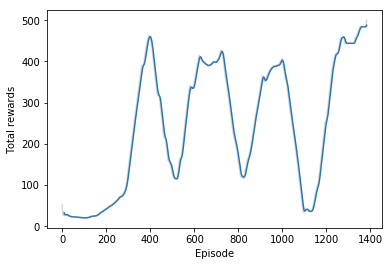

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

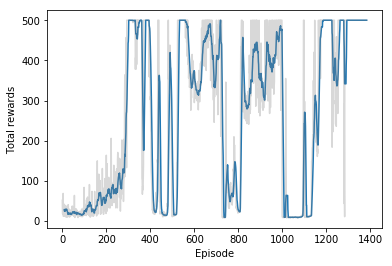

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

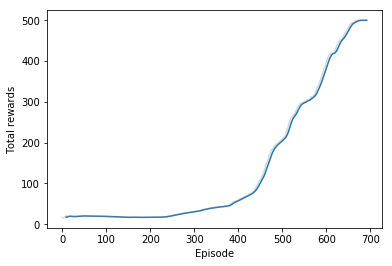

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

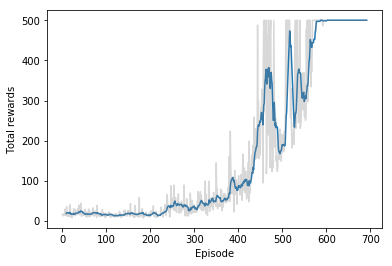

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

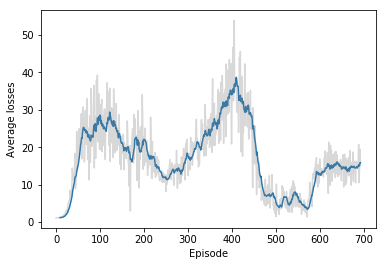

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

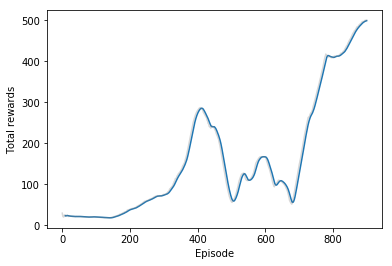

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

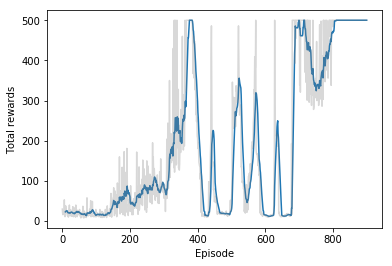

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

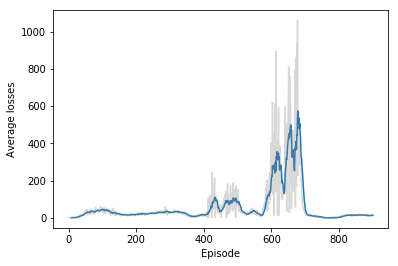

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.